## Problem 2

### Given the data in problem2.csv
1. Calculate the pairwise covariance matrix of the data.
2. Is the Matrix at least positive semi-definite? Why?
3. If not, find the nearest positive semi-definite matrix using Higham’s method and the
near-psd method of Rebenato and Jackel.
4. Calculate the covariance matrix using only overlapping data.
5. Compare the results of the covariance matrices in C and D. Explain the differences.
Note: the generating process is a covariance matrix with 1 on the diagonals and 0.99
elsewhere.


In [4]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigh
from scipy.linalg import sqrtm
from numpy.linalg import norm

## all needed functions

In [5]:
# Load the dataset
data = pd.read_csv('problem2.csv')

# A. Calculate the pairwise covariance matrix of the data
cov_matrix = data.cov()    
print("Pairwise Covariance Matrix:")
print(cov_matrix)

Pairwise Covariance Matrix:
          x1        x2        x3        x4        x5
x1  1.470484  1.454214  0.877269  1.903226  1.444361
x2  1.454214  1.252078  0.539548  1.621918  1.237877
x3  0.877269  0.539548  1.272425  1.171959  1.091912
x4  1.903226  1.621918  1.171959  1.814469  1.589729
x5  1.444361  1.237877  1.091912  1.589729  1.396186


In [6]:
# B. Check if the matrix is at least positive semi-definite
def is_positive_semi_definite(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    return np.all(eigenvalues >= 0)

is_psd = is_positive_semi_definite(cov_matrix)
print(f"Is the covariance matrix positive semi-definite? {is_psd}")

Is the covariance matrix positive semi-definite? False


In [10]:

## using Higham's method to find the nearest positive semi-definite matrix
## setting a fixed value of 0.001 instead of 0 for negative eigenvalues

def projection1(matrix):
    matrix1 = matrix.copy()
    np.fill_diagonal(matrix1, 1)
    return matrix1
    

def projection2(matrix):
    eigvals, eigvecs = eigh(matrix)
    eigvals[eigvals < 0] = 1e-8
    eigvals = np.diag(eigvals)
    return eigvecs @ eigvals @ eigvecs.T #weight as 1, neglected

std_devs=np.sqrt(np.diag(cov_matrix))

init_corr_matrix = np.diag(1/std_devs) @ cov_matrix @ np.diag(1/std_devs)

def from_corr_to_cov(corr_matrix, std_devs):
    return np.diag(std_devs) @ corr_matrix @ np.diag(std_devs)

tol=1e-8
max_iter=1000
def higham_psd(matrix):
    global tol, max_iter
    Yk=matrix
    delta_Sk=np.zeros(matrix.shape)
    for i in range(max_iter):
        Rk=Yk-delta_Sk
        Xk=projection2(Rk)
        delta_Sk=Xk-Rk
        if norm(Yk-projection1(Xk), 'fro')<tol:
            Yk=projection1(Xk)
            print("iteration:", i)
            break
        Yk=projection1(Xk)
    return Yk     

higham_corr_matrix = higham_psd(init_corr_matrix)
higham_cov_matrix = from_corr_to_cov(higham_corr_matrix, std_devs)
new_psd=is_positive_semi_definite(higham_cov_matrix)   

# Higham's method
if new_psd:
    print("Nearest Positive Semi-Definite Matrix using Higham's method:")
    print(higham_cov_matrix)
else:
    print("Higham's method failed to find a positive semi-definite matrix")
    print(higham_cov_matrix)
    print(np.linalg.eigvals(higham_cov_matrix))

# Rebonato and Jackel's method
# Simply remove columns and rows with negative eigenvalues
def rebonato_jackel(matrix):
    eigvals, eigvecs = eigh(matrix)
    eigvals[eigvals < 0] = 0
    T = np.diag(1/(eigvecs @ np.diag(eigvals) @ eigvecs.T))
    B=sqrtm(np.diag(T)) @ eigvecs @ sqrtm(np.diag(eigvals))
    return B @ B.T


print()
print("Nearest Positive Semi-Definite Matrix using Rebonato and Jackel's method:")
rebonato_jackel_corr_matrix = rebonato_jackel(init_corr_matrix)
rebonato_jackel_cov_matrix = from_corr_to_cov(rebonato_jackel_corr_matrix, std_devs)
print(rebonato_jackel_cov_matrix)

iteration: 48
Nearest Positive Semi-Definite Matrix using Higham's method:
[[1.47048437 1.33236075 0.88437762 1.62760181 1.3995556 ]
 [1.33236075 1.25207795 0.619028   1.45060409 1.21445034]
 [0.88437762 0.619028   1.272425   1.07684649 1.05965831]
 [1.62760181 1.45060409 1.07684649 1.81446921 1.57792822]
 [1.3995556  1.21445034 1.05965831 1.57792822 1.39618646]]

Nearest Positive Semi-Definite Matrix using Rebonato and Jackel's method:
[[1.47048437 1.3270091  0.84258339 1.62446381 1.36483264]
 [1.3270091  1.25207795 0.55542072 1.43310934 1.16590627]
 [0.84258339 0.55542072 1.272425   1.05278908 1.06042417]
 [1.62446381 1.43310934 1.05278908 1.81446921 1.54499251]
 [1.36483264 1.16590627 1.06042417 1.54499251 1.39618646]]


In [11]:

# D. Calculate the covariance matrix using only overlapping data
overlapping_data = data.dropna()
cov_matrix_overlapping = overlapping_data.cov()  # Ensure it's a NumPy array
print("Covariance Matrix using only overlapping data:")
print(cov_matrix_overlapping)



Covariance Matrix using only overlapping data:
          x1        x2        x3        x4        x5
x1  0.418604  0.394054  0.424457  0.416382  0.434287
x2  0.394054  0.396786  0.409343  0.398401  0.422631
x3  0.424457  0.409343  0.441360  0.428441  0.448957
x4  0.416382  0.398401  0.428441  0.437274  0.440167
x5  0.434287  0.422631  0.448957  0.440167  0.466272


The differences between the original and the Higham's method covariance matrices are:
1. The C answers uses more data that D, which is more accurate
2. The Higham's method converges more and is the closest
3. The Rebonato and Jackel's method is the simplest and fastest, which leaves out the negative eigenvalues
4. The overlapping uses less data, so the covariance is rather small


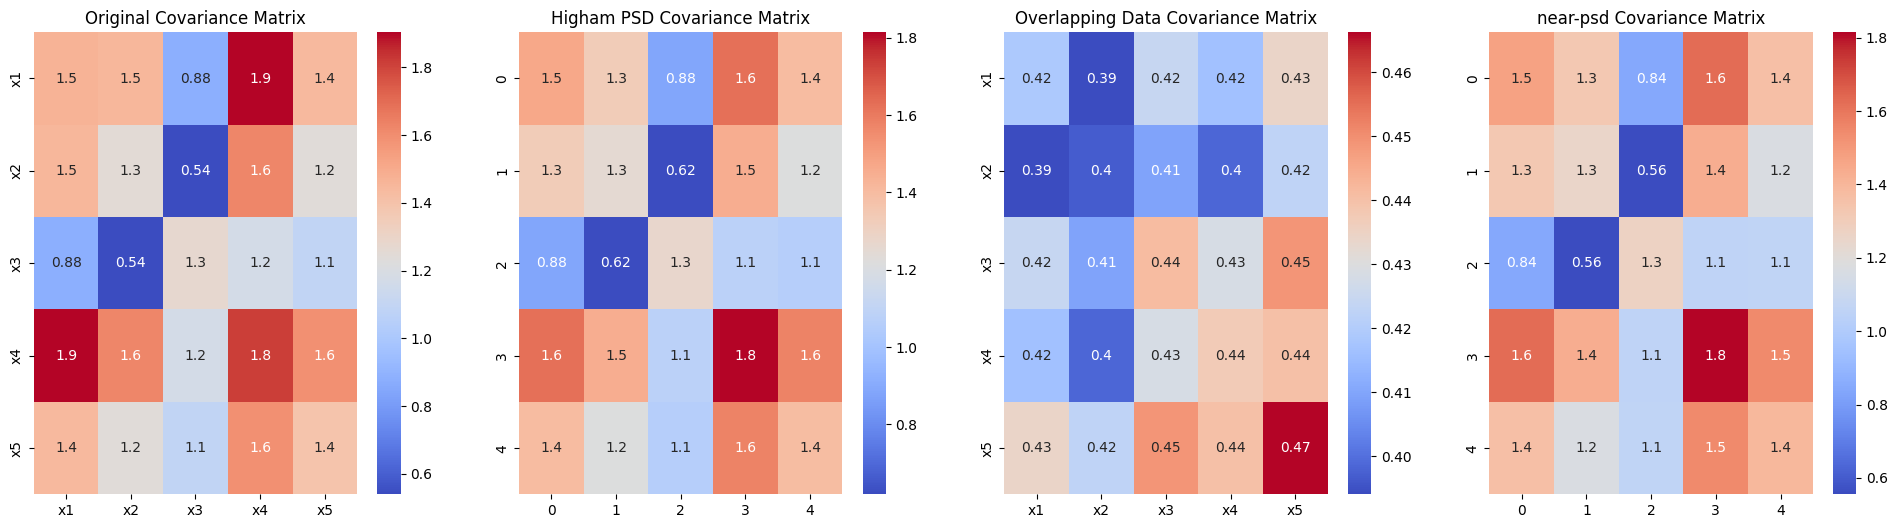

In [12]:
## E. Compare the two covariance matrices

plt.figure(figsize=(24, 6))

plt.subplot(1, 4, 1)
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm')
plt.title('Original Covariance Matrix')

plt.subplot(1, 4, 2)
sns.heatmap(higham_cov_matrix, annot=True, cmap='coolwarm')
plt.title('Higham PSD Covariance Matrix')

plt.subplot(1, 4, 3)
sns.heatmap(cov_matrix_overlapping, annot=True, cmap='coolwarm')
plt.title('Overlapping Data Covariance Matrix')

plt.subplot(1, 4, 4)
sns.heatmap(rebonato_jackel_cov_matrix, annot=True, cmap='coolwarm')
plt.title('near-psd Covariance Matrix')

plt.tight_layout

print("The differences between the original and the Higham's method covariance matrices are:")
print("1. The C answers uses more data that D, which is more accurate")
print("2. The Higham's method converges more and is the closest")
print("3. The Rebonato and Jackel's method is the simplest and fastest, which leaves out the negative eigenvalues")
print("4. The overlapping uses less data, so the covariance is rather small")
